### Momentum balance in Weddell Sea

This notebook is for analysing depth-averaged momentum budget terms in the Weddell gyre region. The intent is to understand the main balances in this region in a hirarchy of model resolutions.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from xgcm import Grid
from dask.diagnostics import ProgressBar
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import glob, os

In [2]:
def plot_sec(ax, da, vmin=-999, vmax=999, vstep=1, lat_lon_ext = [-180, 180, -85., 85.],
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?'):
    
    contours = np.arange(vmin, vmax+vstep, vstep)
    
    p = da.plot(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, cmap=cmap, 
                transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False)
    
    # add separate colorbar
    cb = plt.colorbar(p, ax=ax, format='%.1e', extend='both', shrink=0.6)
    cb.ax.tick_params(labelsize=12)
    
    ax.set_extent(lat_lon_ext, crs=ccrs.PlateCarree())
    
    # parallels/meridiens
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    #gl.ylocator = mticker.FixedLocator([-80, -70, -60, -50, -40, -30])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    
    #ax.set_adjustable('datalim')
    
    ax.set_aspect(1.2)

    #p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    
    _ = plt.title(title, fontsize=14)
    return fig

### Read data of 1/8 and 1/4 degree simualtions

In [3]:
ds_125 = xr.open_dataset("/work/Hemant.Khatri/MOM6_idealised/MOM_budget/Global_MOM6/v2/Mom_Budget_OM125_0001_0005.nc")

#ds_25 = xr.open_dataset("/work/Hemant.Khatri/MOM6_idealised/MOM_budget/Global_MOM6/Mom_Budget_OM25_0001_0005.nc")

In [4]:
print(ds_125)

<xarray.Dataset>
Dimensions:             (xh: 2880, xq: 2880, yh: 2240, yq: 2240)
Coordinates:
  * xh                  (xh) float64 -298.6 -298.5 -298.4 ... 61.05 61.16 61.28
  * yh                  (yh) float64 -83.62 -83.58 -83.54 ... 89.86 89.92 89.97
  * xq                  (xq) float64 -298.5 -298.4 -298.3 ... 61.12 61.23 61.35
  * yq                  (yq) float64 -83.6 -83.56 -83.52 ... 89.89 89.95 90.0
Data variables:
    hf_CAu_2d           (yh, xq) float32 ...
    hf_CAv_2d           (yq, xh) float32 ...
    hf_PFu_2d           (yh, xq) float32 ...
    hf_PFv_2d           (yq, xh) float32 ...
    hf_diffu_2d         (yh, xq) float32 ...
    hf_diffv_2d         (yq, xh) float32 ...
    hf_du_dt_visc_2d    (yh, xq) float32 ...
    hf_dudt_2d          (yh, xq) float32 ...
    hf_dv_dt_visc_2d    (yq, xh) float32 ...
    hf_dvdt_2d          (yq, xh) float32 ...
    hf_gKEu_2d          (yh, xq) float32 ...
    hf_gKEv_2d          (yq, xh) float32 ...
    hf_rvxu_2d          (yq, xh

### Momentum budget for 1/8 deg run

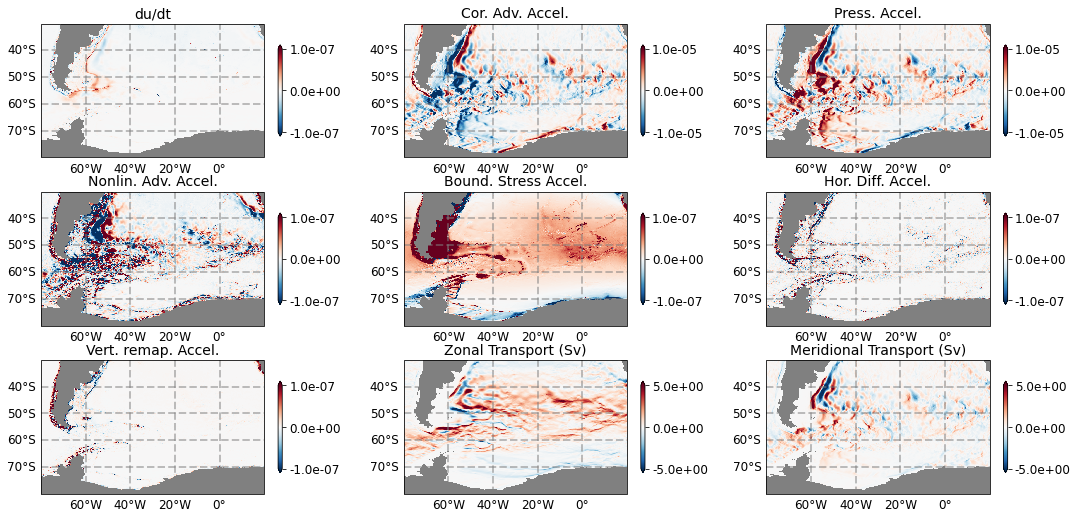

In [5]:
# Zonal Momentum Budget

ds = ds_125.sel(yh = slice(-85,-30.), yq = slice(-85,-30.), xh = slice(-80, 60.), xq = slice(-80, 60.))

max_r = 1.e-7
lat_lon_ext = [-80., 20., -80., -30.]

grid1 = plt.GridSpec(3, 3, wspace=0.3, hspace=0.1)
fig = plt.figure(figsize=[18,9])

tmp = ds['hf_dudt_2d'].assign_coords({'geolat_u': ds['geolat_u'], 'geolon_u': ds['geolon_u']})
ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, tmp, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='du/dt')

tmp = (ds['hf_CAu_2d'] - ds['hf_gKEu_2d'] - ds['hf_rvxv_2d']).assign_coords({'geolat_u': ds['geolat_u'], 'geolon_u': ds['geolon_u']})
ax = fig.add_subplot(grid1[0, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, tmp, vmin=-1e2*max_r, vmax=1e2*max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Cor. Adv. Accel.')

tmp = (ds['hf_PFu_2d']+ds['hf_u_BT_accel_2d']).assign_coords({'geolat_u': ds['geolat_u'], 'geolon_u': ds['geolon_u']})
ax = fig.add_subplot(grid1[0, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, tmp, vmin=-1e2*max_r, vmax=1e2*max_r,  vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Press. Accel.')

tmp = (ds['hf_gKEu_2d'] + ds['hf_rvxv_2d']).assign_coords({'geolat_u': ds['geolat_u'], 'geolon_u': ds['geolon_u']})
ax = fig.add_subplot(grid1[1, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, tmp, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Nonlin. Adv. Accel.')

tmp = ds['hf_du_dt_visc_2d'].assign_coords({'geolat_u': ds['geolat_u'], 'geolon_u': ds['geolon_u']})
ax = fig.add_subplot(grid1[1, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, tmp, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Bound. Stress Accel.')

tmp = ds['hf_diffu_2d'].assign_coords({'geolat_u': ds['geolat_u'], 'geolon_u': ds['geolon_u']})
ax = fig.add_subplot(grid1[1, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, tmp, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Hor. Diff. Accel.')

tmp1 = (ds['hf_dudt_2d']-ds['hf_CAu_2d']-ds['hf_PFu_2d']-ds['hf_diffu_2d']-ds['hf_du_dt_visc_2d']-
       ds['hf_u_BT_accel_2d']).assign_coords({'geolat_u': ds['geolat_u'], 'geolon_u': ds['geolon_u']})
ax = fig.add_subplot(grid1[2, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, tmp1, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Vert. remap. Accel.')

tmp = (ds['umo'] / (ds['wet_u'] * 1.e6 * 1035.)).assign_coords({'geolat_u': ds['geolat_u'], 'geolon_u': ds['geolon_u']})
ax = fig.add_subplot(grid1[2, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, tmp , vmin=-5, vmax=5, vstep=2., lat_lon_ext = lat_lon_ext,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Zonal Transport (Sv)')

tmp = (ds['vmo']/ (ds['wet_v'] *1.e6 * 1035.)).assign_coords({'geolat_v': ds['geolat_v'], 'geolon_v': ds['geolon_v']})
#tmp = tmp.where(tmp1 != np.nan)
ax = fig.add_subplot(grid1[2, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, tmp , vmin=-5, vmax=5, vstep=2., lat_lon_ext = lat_lon_ext,
                   lon='geolon_v', lat='geolat_v', cmap='RdBu_r', title='Meridional Transport (Sv)')

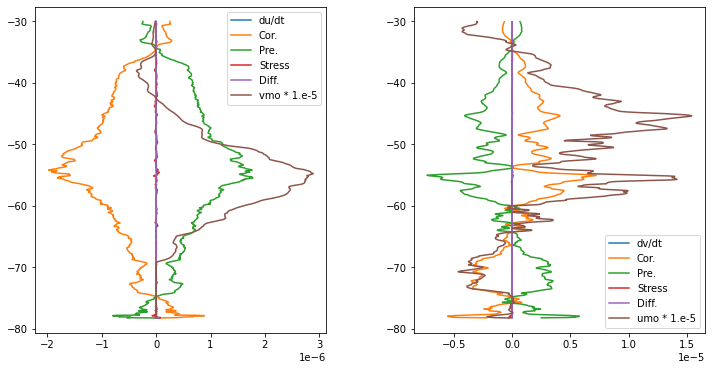

In [6]:
# Zonal-average budget 

ds = ds_125.sel(yh = slice(-85,-30.), yq = slice(-85,-30.), xh = slice(-65, 20.), xq = slice(-65, 20.))

grid1 = plt.GridSpec(1, 2, wspace=0.3, hspace=0.1)
fig = plt.figure(figsize=[12,6])

ax = fig.add_subplot(grid1[0, 0])
ax.plot(ds['hf_dudt_2d'].mean('xq'),ds['geolat_u'].mean('xq'),label='du/dt')
ax.plot((ds['hf_CAu_2d'] - ds['hf_gKEu_2d'] - ds['hf_rvxv_2d']).mean('xq'),ds['geolat_u'].mean('xq'),label='Cor.')
ax.plot((ds['hf_PFu_2d']+ds['hf_u_BT_accel_2d']).mean('xq'),ds['geolat_u'].mean('xq'),label='Pre.')
ax.plot((ds['hf_gKEu_2d'] + ds['hf_rvxv_2d']).mean('xq'),ds['geolat_u'].mean('xq'),label='Stress')
ax.plot(ds['hf_diffu_2d'].mean('xq'),ds['geolat_u'].mean('xq'),label='Diff.')
ax.plot((ds['vmo'] * 1.e-5 / (ds['wet_v'] *1.e6 * 1035.)).mean('xh'), ds['geolat_v'].mean('xh'),label='vmo * 1.e-5')
ax.legend()

ax = fig.add_subplot(grid1[0, 1])
ax.plot(ds['hf_dvdt_2d'].mean('xh'),ds['geolat_v'].mean('xh'),label='dv/dt')
ax.plot((ds['hf_CAv_2d'] - ds['hf_gKEv_2d'] - ds['hf_rvxu_2d']).mean('xh'),ds['geolat_v'].mean('xh'),label='Cor.')
ax.plot((ds['hf_PFv_2d']+ds['hf_v_BT_accel_2d']).mean('xh'),ds['geolat_v'].mean('xh'),label='Pre.')
ax.plot((ds['hf_gKEv_2d'] + ds['hf_rvxu_2d']).mean('xh'),ds['geolat_v'].mean('xh'),label='Stress')
ax.plot(ds['hf_diffv_2d'].mean('xh'),ds['geolat_v'].mean('xh'),label='Diff.')
ax.plot((ds['umo'] * 1.e-5 / (ds['wet_u'] *1.e6 * 1035.)).mean('xq'), ds['geolat_u'].mean('xq'),label='umo * 1.e-5')
ax.legend()

In [16]:
# Check depth-integrated u, v from Corilis term against umo, vmo

ds = ds_125
rho_0 = 1035.

grid = Grid(ds_125, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'} }, periodic=[ ])

f_u = grid.interp(ds['Coriolis'], 'Y',  boundary='fill')
f_v = grid.interp(ds['Coriolis'], 'X',  boundary='fill')

v_f = (f_v * ds['vmo'] / (rho_0 * ds['dxCv']))
u_f = (f_u * ds['umo'] / (rho_0 * ds['dyCu']))

v_f = v_f.assign_coords({'geolat_v': ds['geolat_v'], 'geolon_v': ds['geolon_v']})

u_f = u_f.assign_coords({'geolat_u': ds['geolat_u'], 'geolon_u': ds['geolon_u']})

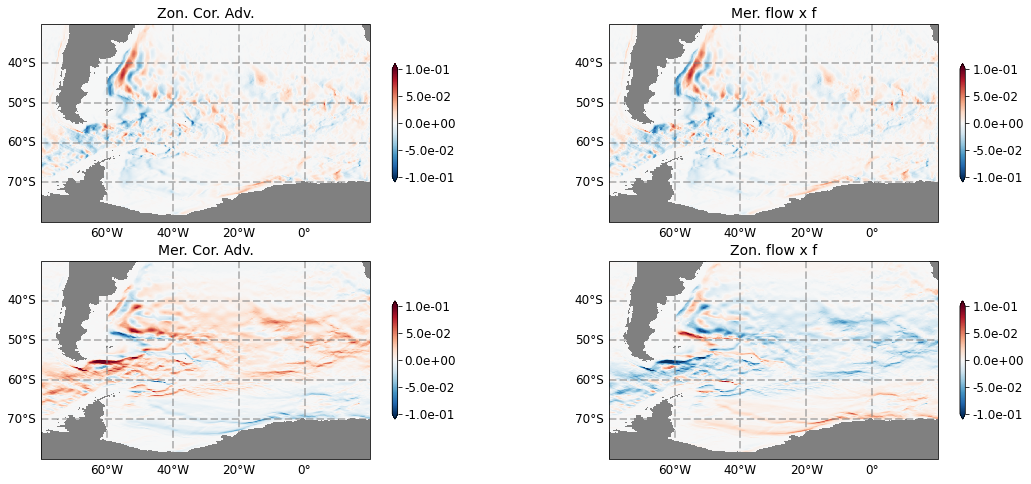

In [31]:
ds = ds_125.sel(yh = slice(-85,-30.), yq = slice(-85,-30.), xh = slice(-80, 60.), xq = slice(-80, 60.))
lat_lon_ext = [-80., 20., -80., -30.]

max_r = 1.e-3

grid1 = plt.GridSpec(2, 2, wspace=0.3, hspace=0.2)
fig = plt.figure(figsize=[18,8])

tmp1 = (ds['intz_CAu_2d'] - ds['intz_gKEu_2d'] - ds['intz_rvxv_2d']).assign_coords({'geolat_u': ds['geolat_u'], 'geolon_u': ds['geolon_u']})
ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, tmp1, vmin=-1e2*max_r, vmax=1e2*max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Zon. Cor. Adv.')

tmp2 = v_f.sel(yq = slice(-85,-30.), xh = slice(-80, 60.)) / ds['wet_v']
ax = fig.add_subplot(grid1[0, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, tmp2, vmin=-1e2*max_r, vmax=1e2*max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_v', lat='geolat_v', cmap='RdBu_r', title='Mer. flow x f')  

tmp1 = (ds['intz_CAv_2d'] - ds['intz_gKEv_2d'] - ds['intz_rvxu_2d']).assign_coords({'geolat_v': ds['geolat_v'], 'geolon_v': ds['geolon_v']})
ax = fig.add_subplot(grid1[1, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, tmp1, vmin=-1e2*max_r, vmax=1e2*max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_v', lat='geolat_v', cmap='RdBu_r', title='Mer. Cor. Adv.')

tmp2 = u_f.sel(yh = slice(-85,-30.), xq = slice(-80, 60.)) / ds['wet_u']
ax = fig.add_subplot(grid1[1, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, tmp2, vmin=-1e2*max_r, vmax=1e2*max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Zon. flow x f')

            

### Momentum budget for 1/4 deg run

In [8]:
grid = xr.open_dataset("/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20201120/CM4_piControl_c96_OM4p25_half_kdadd/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_monthly/ocean_monthly.static.nc")
print(grid)

<xarray.Dataset>
Dimensions:       (xh: 1440, xq: 1441, yh: 1080, yq: 1081)
Coordinates:
  * xh            (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * xq            (xq) float64 -299.8 -299.6 -299.3 -299.1 ... 59.66 59.91 60.16
  * yh            (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * yq            (yq) float64 -80.43 -80.35 -80.27 -80.19 ... 89.78 89.89 90.0
Data variables:
    Coriolis      (yq, xq) float32 ...
    areacello     (yh, xh) float32 ...
    areacello_bu  (yq, xq) float32 ...
    areacello_cu  (yh, xq) float32 ...
    areacello_cv  (yq, xh) float32 ...
    deptho        (yh, xh) float32 ...
    dxCu          (yh, xq) float32 ...
    dxCv          (yq, xh) float32 ...
    dxt           (yh, xh) float32 ...
    dyCu          (yh, xq) float32 ...
    dyCv          (yq, xh) float32 ...
    dyt           (yh, xh) float32 ...
    geolat        (yh, xh) float32 ...
    geolat_c      (yq, xq) float32 ...
    geolat_u      (yh, xq)

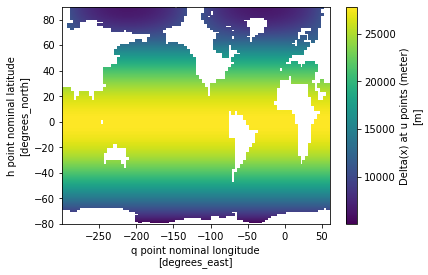

In [10]:
grid.dxCu.plot()

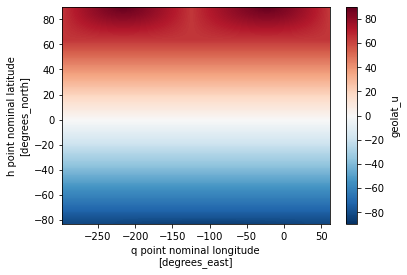

In [17]:
ds_125.geolat_u.plot()

In [24]:
ds.umo.nbytes / 1.e9

0.003815944

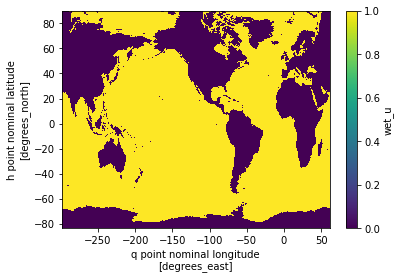

In [11]:
ds_125.wet_u.plot()